In [1]:
#loading data from kaggle api
# !kaggle competitions download -c mitsui-commodity-prediction-challenge

In [2]:
#unzipping data
# !unzip mitsui-commodity-prediction-challenge.zip

In [3]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('seaborn-v0_8-darkgrid')
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
target_pairs = pd.read_csv("../data/target_pairs.csv")
train_labels = pd.read_csv("../data/train_labels.csv")
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
test_labels_lag_1 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_1.csv")
test_labels_lag_2 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_2.csv")
test_labels_lag_3 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_3.csv")
test_labels_lag_4 = pd.read_csv("../data/lagged_test_labels/test_labels_lag_4.csv")

In [5]:
# setting base date and conversion of dates

base_date = pd.Timestamp("2000-01-01")
train['date_id'] = pd.to_timedelta(train['date_id'], unit='D') + base_date
train_labels['date_id'] = pd.to_timedelta(train_labels['date_id'], unit='D') + base_date



In [6]:
#finding merge key

print("Train columns:", train.columns.tolist())
print("Train_labels columns:", train_labels.columns.tolist())

Train columns: ['date_id', 'LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close', 'JPX_Gold_Mini_Futures_Open', 'JPX_Gold_Rolling-Spot_Futures_Open', 'JPX_Gold_Standard_Futures_Open', 'JPX_Platinum_Mini_Futures_Open', 'JPX_Platinum_Standard_Futures_Open', 'JPX_RSS3_Rubber_Futures_Open', 'JPX_Gold_Mini_Futures_High', 'JPX_Gold_Rolling-Spot_Futures_High', 'JPX_Gold_Standard_Futures_High', 'JPX_Platinum_Mini_Futures_High', 'JPX_Platinum_Standard_Futures_High', 'JPX_RSS3_Rubber_Futures_High', 'JPX_Gold_Mini_Futures_Low', 'JPX_Gold_Rolling-Spot_Futures_Low', 'JPX_Gold_Standard_Futures_Low', 'JPX_Platinum_Mini_Futures_Low', 'JPX_Platinum_Standard_Futures_Low', 'JPX_RSS3_Rubber_Futures_Low', 'JPX_Gold_Mini_Futures_Close', 'JPX_Gold_Rolling-Spot_Futures_Close', 'JPX_Gold_Standard_Futures_Close', 'JPX_Platinum_Mini_Futures_Close', 'JPX_Platinum_Standard_Futures_Close', 'JPX_RSS3_Rubber_Futures_Close', 'JPX_Gold_Mini_Futures_Volume', 'JPX_Gold_Rolling-Spot_Futures_Volume', 'JPX_Gold_Sta

In [7]:
#merging data and displaying as table
merge_key = 'row_id' if 'row_id' in train.columns else train.columns.intersection(train_labels.columns)[0]
train_full = pd.merge(train, train_labels, on=merge_key, how='left')
print(f"Merged shape: {train_full.shape}")
display(train_full.head())

Merged shape: (1961, 982)


,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,target_414,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423
0,2000-01-01,"2,264.5000","7,205.0000","2,570.0000","3,349.0000",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0212,-0.0056,NaN,-0.0046,0.0338,NaN,0.0382,NaN,0.0273
1,2000-01-02,"2,228.0000","7,147.0000","2,579.0000","3,327.0000",NaN,NaN,NaN,NaN,NaN,...,0.0034,0.0214,-0.0015,0.0128,0.0105,0.0305,-0.0008,0.0250,0.0035,0.0209
2,2000-01-03,"2,250.0000","7,188.5000","2,587.0000","3,362.0000","4,684.0000","4,691.0000","4,684.0000","3,363.0000","3,367.0000",...,-0.0067,0.0093,0.0019,-0.0128,-0.0023,0.0175,-0.0054,0.0048,-0.0091,0.0017
3,2000-01-04,"2,202.5000","7,121.0000","2,540.0000","3,354.0000","4,728.0000","4,737.0000","4,729.0000","3,430.0000","3,426.0000",...,NaN,0.0369,-0.0152,NaN,0.0081,0.0011,NaN,-0.0151,NaN,-0.0330
4,2000-01-05,"2,175.0000","7,125.0000","2,604.0000","3,386.0000",NaN,NaN,NaN,NaN,NaN,...,NaN,0.0049,NaN,-0.0067,-0.0161,-0.0049,NaN,NaN,0.0095,NaN


In [8]:
#basic info & missing data
print("\n--- Dataset Info ---")
train_full.info()

print("\n--- Missing Values ---")
print(train_full.isnull().sum().sort_values(ascending=False))



--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Columns: 982 entries, date_id to target_423
dtypes: datetime64[ns](1), float64(981)
memory usage: 14.7 MB

--- Missing Values ---
US_Stock_GOLD_adj_close     1713
US_Stock_GOLD_adj_volume    1713
US_Stock_GOLD_adj_low       1713
US_Stock_GOLD_adj_open      1713
US_Stock_GOLD_adj_high      1713
                            ... 
FX_EURUSD                      0
FX_GBPJPY                      0
FX_GBPAUD                      0
FX_GBPUSD                      0
date_id                        0
Length: 982, dtype: int64


In [9]:
# #debugging
# print(train['date_id'].head(10))
# print(train['date_id'].dtype)
# display(train_full.describe())


In [10]:
#time handling

time_col = [c for c in train_full.columns if 'date' in c.lower() or 'time' in c.lower()][0]
train_full[time_col] = pd.to_datetime(train_full[time_col])
train_full = train_full.sort_values(by=time_col)

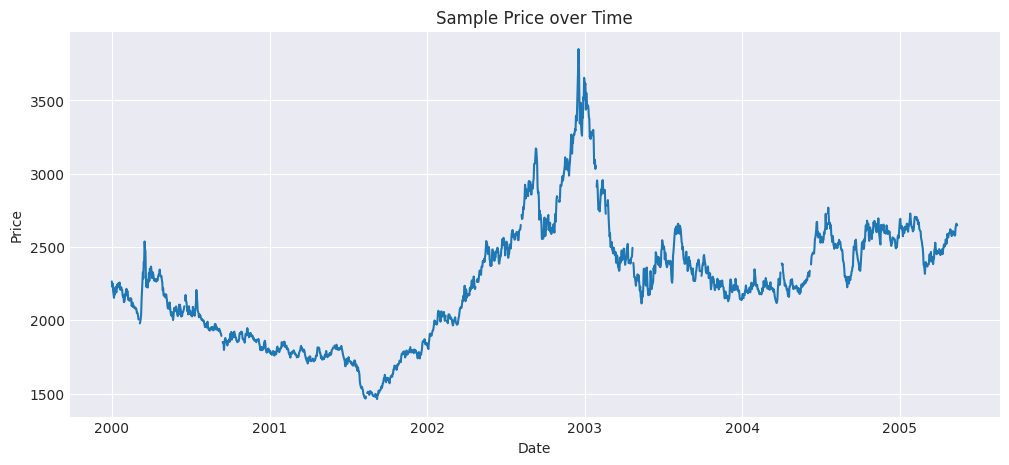

In [11]:
#example commodity

if 'commodity' in train_full.columns:
    sample_asset = train_full['commodity'].unique()[0]
    subset = train_full[train_full['commodity'] == sample_asset]
else:
    subset = train_full

plt.figure(figsize=(12,5))
plt.plot(subset[time_col], subset.select_dtypes('number').iloc[:,0])
plt.title(f"{sample_asset if 'commodity' in train_full.columns else 'Sample'} Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

/tmp/ipykernel_5701/952096326.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  train_full['Return'] = train_full[price_col].pct_change()


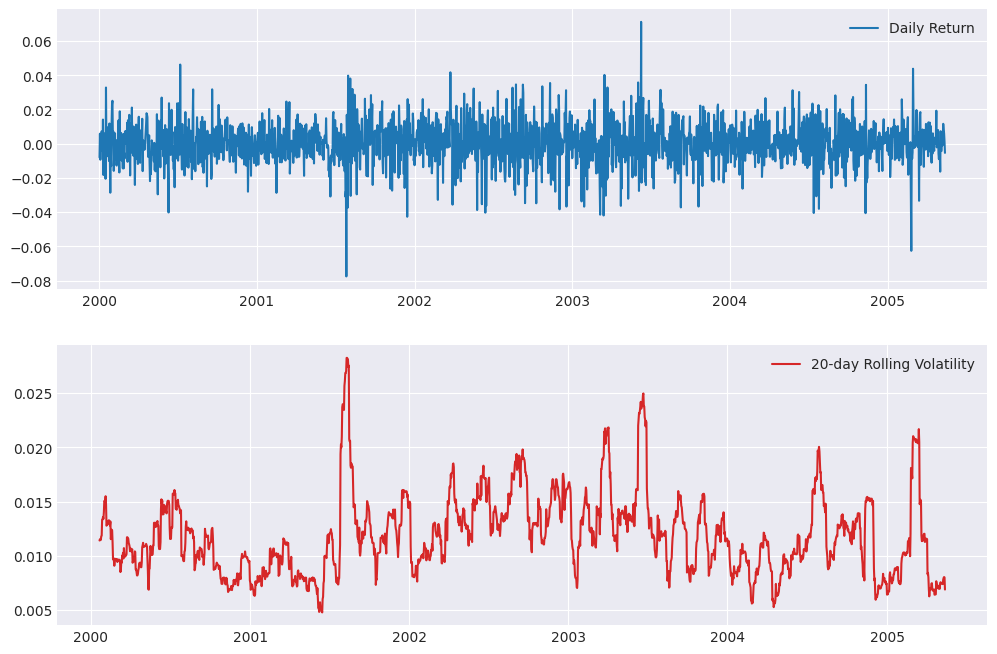

In [12]:
#compute returns and volatility
numeric_cols = train_full.select_dtypes(include=np.number).columns
price_col = numeric_cols[1] if len(numeric_cols) > 1 else numeric_cols[0]

train_full['Return'] = train_full[price_col].pct_change()
train_full['Volatility'] = train_full['Return'].rolling(window=20).std()

fig, ax = plt.subplots(2,1,figsize=(12,8))
ax[0].plot(train_full[time_col], train_full['Return'], label='Daily Return', color='tab:blue')
ax[1].plot(train_full[time_col], train_full['Volatility'], label='20-day Rolling Volatility', color='tab:red')
ax[0].legend(); ax[1].legend()
plt.show()

In [13]:
#stationarity test
print("\n--- Augmented Dickey-Fuller Test on Returns ---")
adf_result = adfuller(train_full['Return'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] <= 0.05:
    print("✅ Series is likely stationary.")
else:
    print("⚠️ Series is non-stationary; consider differencing or transformation.")


--- Augmented Dickey-Fuller Test on Returns ---
ADF Statistic: -45.2819
p-value: 0.0000
✅ Series is likely stationary.


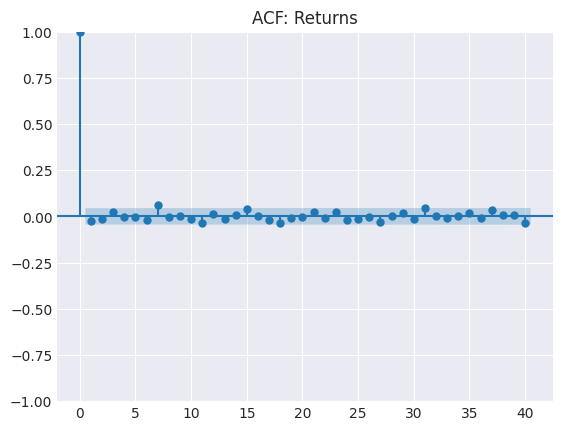

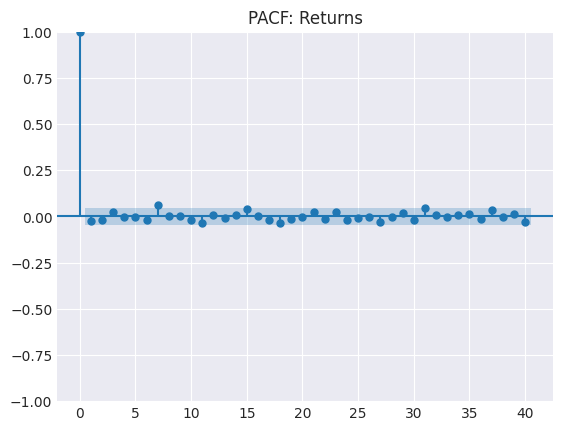

In [14]:
#autocorrelation analysis
plot_acf(train_full['Return'].dropna(), lags=40, title="ACF: Returns")
plot_pacf(train_full['Return'].dropna(), lags=40, title="PACF: Returns")
plt.show()


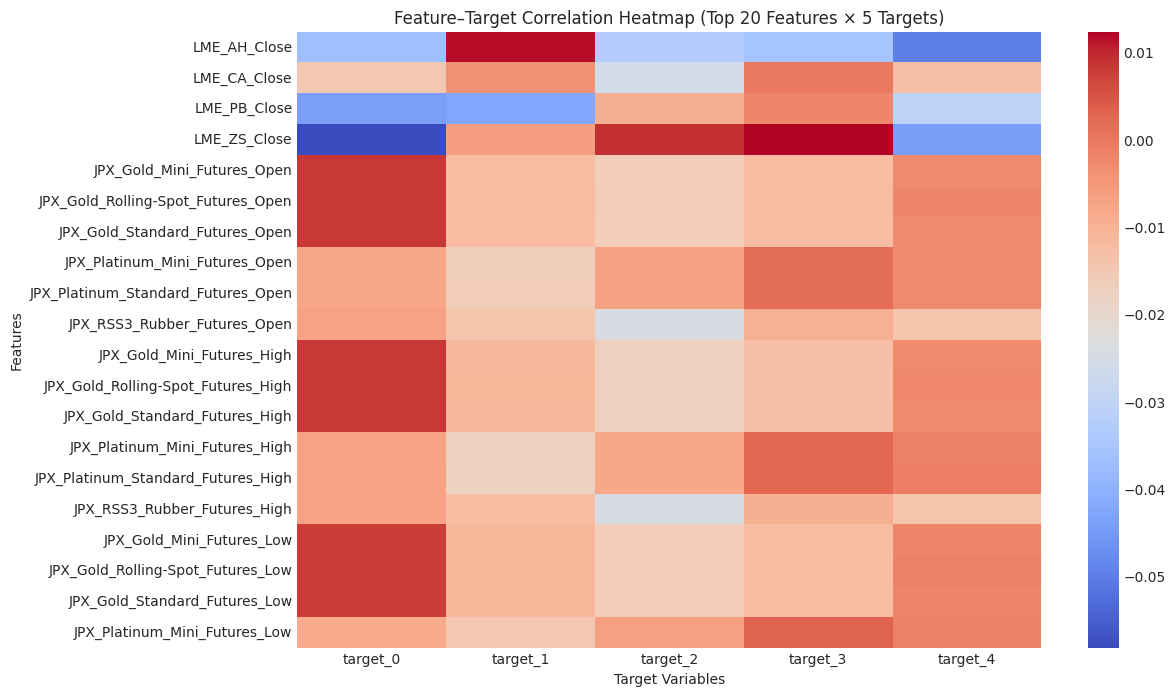

In [15]:
#correlation matrix  (important features)

target_cols = [c for c in train_full.columns if c.startswith('target_')]
feature_cols = [c for c in train_full.columns if not c.startswith('target_') and c != 'date_id']

corr = train_full[feature_cols + target_cols].corr().loc[feature_cols, target_cols]

plt.figure(figsize=(12, 8))
sns.heatmap(corr.iloc[:20, :5], annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Feature–Target Correlation Heatmap (Top 20 Features × 5 Targets)")
plt.xlabel("Target Variables")
plt.ylabel("Features")
plt.show()

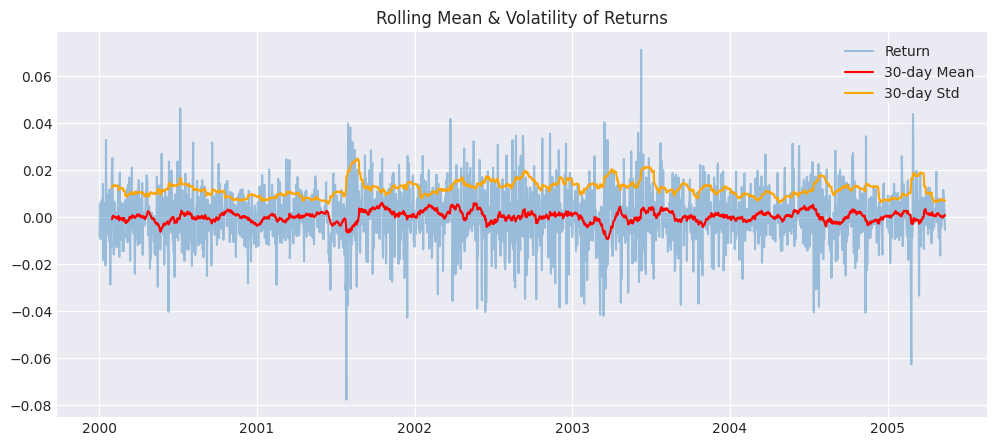

In [16]:
#rolling mean & std visualization
window = 30
train_full['Rolling_Mean'] = train_full['Return'].rolling(window=window).mean()
train_full['Rolling_Std']  = train_full['Return'].rolling(window=window).std()

plt.figure(figsize=(12,5))
plt.plot(train_full[time_col], train_full['Return'], label='Return', alpha=0.4)
plt.plot(train_full[time_col], train_full['Rolling_Mean'], label=f'{window}-day Mean', color='red')
plt.plot(train_full[time_col], train_full['Rolling_Std'], label=f'{window}-day Std', color='orange')
plt.title("Rolling Mean & Volatility of Returns")
plt.legend()
plt.show()

In [17]:
#Summary
print(f"Records: {len(train_full):,}")
print(f"Date Range: {train_full[time_col].min()} → {train_full[time_col].max()}")
print(f"Missing Values: {train_full.isna().sum().sum()}")
print(f"Average Daily Return: {train_full['Return'].mean():.4f}")
print(f"Average Volatility (20-day): {train_full['Volatility'].mean():.4f}")


Records: 1,961
Date Range: 2000-01-01 00:00:00 → 2005-05-14 00:00:00
Missing Values: 132538
Average Daily Return: 0.0002
Average Volatility (20-day): 0.0119


In [18]:
# #handling missing values
# # Sort chronologically (important for time-series)
# train_full = train_full.sort_values(by=time_col)

# # Forward-fill then backward-fill missing data
# train_full = train_full.fillna(method='ffill').fillna(method='bfill')

# # Drop columns that are entirely NaN or mostly empty (>40%)
# missing_ratio = train_full.isna().mean()
# cols_to_drop = missing_ratio[missing_ratio > 0.4].index
# train_full = train_full.drop(columns=cols_to_drop)
# print(f"Dropped {len(cols_to_drop)} columns with >40% missing data.")
# print(f"Remaining missing entries: {train_full.isna().sum().sum()}")


In [19]:
# #handling outliers
# numeric_cols = train_full.select_dtypes(include=['float64', 'int64']).columns
# # Clip extreme values to 1st–99th percentile (winsorization)
# for col in numeric_cols:
#     q_low, q_high = train_full[col].quantile([0.01, 0.99])
#     train_full[col] = train_full[col].clip(lower=q_low, upper=q_high)

# print(f"Outliers clipped {len(numeric_cols)} numeric columns.")
